### NYC Taxi trips data
Our goal is to predict the number of NY City yellow taxi pickups in the next 1 hour for each of 260 pickup zones.  <br>

To do this, we will use Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.  For the demo, we'll use 8 months of historical data for training, and we will use the built-in feature of Amazon Forecast that reads in 14-day weather predictions as related data. Data used in this demo notebook:<br>

<ul>
<li>Original data source for all open data from 2008-now:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page", target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
    <li>AWS-hosted location:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/", target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
    <li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future weather will be available for other global locations. </li>
    </ul>
  
  
### Raw data gathering

The raw data is split 1 month per file, per Yellow, Green, or ForHire from 2008 through 2020, with each file around 600MB.  The entire raw data S3 bucket is HUGE.  <br>

I downloaded just 8 files:  yellow cabs June-Dec 2019, Jan-Feb 2020 to avoid COVID effects.  I processed them using AWS Glue and cleaned using Amazon Athena.<br>

### Data cleaning steps (done in Glue and Athena) 
<ul>
    <li>Calculate Trip duration in minutes</li>
    <li>Drop negative trip distances, 0 fares, 0 passengers, less than 1min trip durations </li>
    <li>Drop 2 unknown zones ['264', '265']
</ul>

In [1]:
import sys
import os

import pandas as pd
print('pandas: {}'.format(pd.__version__))
import numpy as np
print('numpy: {}'.format(np.__version__))

# get region from boto3
import boto3
REGION = boto3.Session().region_name

# # importing forecast notebook utility from notebooks/common directory
# sys.path.insert( 0, os.path.abspath("../../common") )
# # import util

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

pandas: 1.0.5
numpy: 1.19.1


### Read target time series required data

We will use the "Custom" schema.  See https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html.  <br>
Note: Domain-specific schemas are for convenience of wording, they have no impact on choice of algorithms or models. <br>

The documentation says the following fields are required for Custom schema:
<ul>
    <li>item_id (string) </li>
    <li>timestamp (timestamp) </li>
    <li>target_value (floating-point integer) </li>
    </ul>

Then your input .csv file must include the required columns.  The order of your columns does not matter, but you must have at least the required fields.  


![Image Select required columns for TTS](images/target_time_series_columns.png "Selecting required columns for Target Time Series")
<br>
We will include these required columns + create an additional geolocation "location" column required to use the built-in Amazon Forecast Weather Index.

In [2]:
# Read cleaned Target Time series data

df = pd.read_csv("data/TTS.csv")

# for demo purpose, drop geolocation and show how it was created
df.drop("location", axis=1, inplace=True)
print(df.shape)
print(df.dtypes)
print(f"num items:  {df.item_id.nunique()}")
start_time = df.timestamp.min()
end_time = df.timestamp.max()
print(f"start time: {start_time}")
print(f"end time: {end_time}")
df.sample(5)


(648414, 3)
timestamp       object
item_id          int64
actual_value     int64
dtype: object
num items:  260
start time: 2019-07-01 00:00:00
end time: 2020-02-29 23:00:00


,timestamp,item_id,actual_value
94612,2019-08-03 09:00:00,28,1
88272,2019-08-01 03:00:00,179,1
226430,2019-09-20 17:00:00,162,721
540575,2020-01-18 00:00:00,107,224
249489,2019-09-29 01:00:00,24,9


In [3]:

## SINCE WE'RE GOING TO FORECAST AT HOURLY GRANULARITY, GO AHEAD AND AGGREGATE HOURLY

df = df.groupby(['timestamp', 'item_id']).sum()
df.reset_index(inplace=True)
print(f"df: {df.shape}")
df.sample(5)

df: (648414, 3)


,timestamp,item_id,actual_value
19737,2019-07-07 21:00:00,158,64
157631,2019-08-26 13:00:00,246,161
595507,2020-02-09 00:00:00,72,1
618977,2020-02-18 09:00:00,157,2
615483,2020-02-16 22:00:00,158,106


<b>Geolocation data preparation steps</b>

Next, we need to create a geolocation column, to make our data location-aware.
<ul>
    <li>Join converted lat, lon data to raw trips data</li>
    <li>Create "location" column with required string format "lat_lon" </li>
    </ul>

In [4]:
## READ LAT, LON MAPPING FILE

latlon = \
    pd.read_csv("data/taxi_zones.csv")

print(latlon.shape)
print(latlon.dtypes)
latlon.head()

(263, 8)
X             float64
Y             float64
OBJECTID        int64
Shape_Leng    float64
Shape_Area    float64
zone           object
LocationID      int64
borough        object
dtype: object


,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,-74.176786,40.689516,1,0.116357,0.000782,Newark Airport,1,EWR
1,-73.826126,40.625724,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,-73.849479,40.865888,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,-74.189930,40.550340,5,0.092146,0.000498,Arden Heights,5,Staten Island


### Join raw trips data to lat_lon data

In [5]:
## JOIN RAW TAXI DATA WITH LAT, LON FIELDS

joined = df.merge(latlon, left_on="item_id", right_on="LocationID")
print(joined.shape, df.shape)
joined.sample(5)


(648414, 11) (648414, 3)


,timestamp,item_id,actual_value,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
440497,2020-01-25 01:00:00,232,30,-73.982307,40.715386,232,0.061471,0.000216,Two Bridges/Seward Park,232,Manhattan
217686,2020-01-08 17:00:00,125,71,-74.007176,40.725376,125,0.049732,0.000076,Hudson Sq,125,Manhattan
372653,2019-09-04 04:00:00,193,3,-73.940286,40.761724,193,0.065530,0.000146,Queensbridge/Ravenswood,193,Queens
375546,2020-01-21 06:00:00,193,3,-73.940286,40.761724,193,0.065530,0.000146,Queensbridge/Ravenswood,193,Queens
647896,2019-10-27 19:00:00,115,1,-74.092486,40.620128,115,0.116169,0.000373,Grymes Hill/Clifton,115,Staten Island


<br>
In order to use the weather feature in Amazon Forecast, you'll need a "geolocation"-type column with either a Postal Code or the specific format string "lat_lon".  The latitude, longitude values can be your raw values.  We take care of rounding to nearest 0.2 degrees for you, in case that is needed.

<br>

In [6]:

## CONCAT LAT_LON, WHERE "Y" = PICKUP_LATITUDE AND "X" = PICKUP_LONGITUDE

joined['location'] = joined.Y.astype(str) + "_" + joined.X.astype(str)
joined.head()


,timestamp,item_id,actual_value,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,location
0,2019-07-01 00:00:00,4,9,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.72415214_-73.97702292
1,2019-07-01 01:00:00,4,4,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.72415214_-73.97702292
2,2019-07-01 02:00:00,4,2,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.72415214_-73.97702292
3,2019-07-01 03:00:00,4,2,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.72415214_-73.97702292
4,2019-07-01 04:00:00,4,8,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.72415214_-73.97702292


In [7]:

## SELECT JUST THE COLUMNS YOU NEED FOR THE TARGET TIME SERIES

tts = joined[['timestamp', 'item_id', 'actual_value', 'location']].copy()
tts.head()


,timestamp,item_id,actual_value,location
0,2019-07-01 00:00:00,4,9,40.72415214_-73.97702292
1,2019-07-01 01:00:00,4,4,40.72415214_-73.97702292
2,2019-07-01 02:00:00,4,2,40.72415214_-73.97702292
3,2019-07-01 03:00:00,4,2,40.72415214_-73.97702292
4,2019-07-01 04:00:00,4,8,40.72415214_-73.97702292


### Normally, you would save this tts file somewhere.  I've saved it already to data/TTS.csv

Now, let's do a quick visualization.

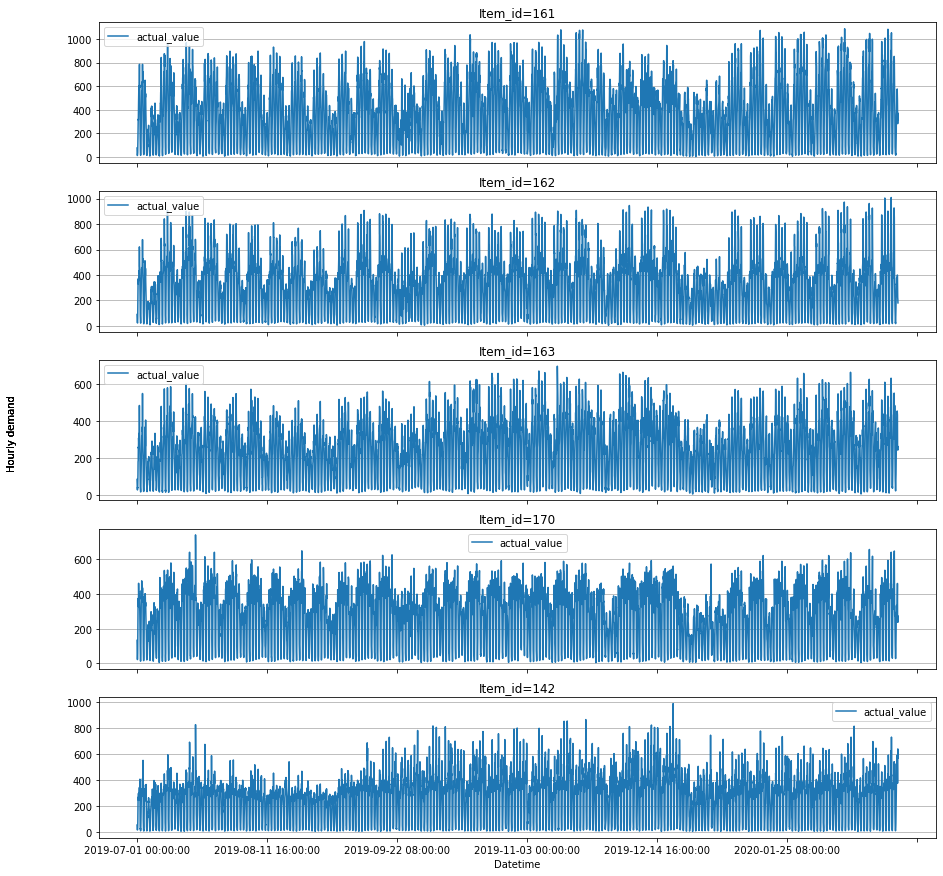

In [8]:
# Visualize items
random_items = [161, 162, 163, 170, 142]
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

# force plot of just raw tts
temp = tts.loc[(tts.item_id.isin(random_items)), ['item_id', 'timestamp', 'actual_value']].copy()
temp.set_index('timestamp', inplace=True)
temp.columns = ['item_id', 'actual_value']
temp.head()

for i in range(len(random_items)):
    item = random_items[i]
    
    # zoomed-in plots
    zoomed = temp.loc[(temp['item_id']==item), :].copy()
#     zoomed = zoomed['2020-02-28':'2020-02-29']
    zoomed[['actual_value']].plot(ax=axs[i], title=f"Item_id={item}")
            
    axs[i].set_xlabel("Datetime")    #date
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    axs[i].grid(which='minor', axis='x')
    axs[i].grid(axis='y')

With the extra geolocation column "location" added, you are ready to feed the Target Time Series into Amazon Forecast,  
<li><a href="./1. Training your model with Weather Index.ipynb", target="_blank">see the next notebook Training your model with Weather Index.</a></li>